# Classification of the Fraudulent Credit Card Transactions

## Importing Libraries

In [57]:
# Importing necessary libraries
import numpy as np
from numpy import mean, std
import pandas as pd
import seaborn as sns
from matplotlib import pyplot
from collections import Counter
import time

# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Other Libraries
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_val_score, GridSearchCV, cross_val_predict, RandomizedSearchCV
from scipy.stats import norm
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report, average_precision_score, roc_curve, confusion_matrix

import warnings
warnings.filterwarnings("ignore")

## Data Exploration

In [4]:
# Reading csv file and summarizing the dataset 
df = pd.read_csv('creditcard.csv')
print(df.shape)
target = df.values[:,-1]
counter = Counter(target)
for k,v in counter.items():
    per = v / len(target) * 100
    print('Class=%d, Count=%d, Percentage=%.3f%%' % (k, v, per))
df.head()

(284807, 31)
Class=0, Count=284315, Percentage=99.827%
Class=1, Count=492, Percentage=0.173%


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
# Dataset statistics
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.758702e-12,-8.252296e-13,-9.637438e-13,8.316234e-13,1.592013e-13,4.247308e-13,-3.050183e-13,8.692882e-14,-1.179710e-12,...,-3.406538e-13,-5.713357e-13,-9.725290e-13,1.464144e-12,-6.989090e-13,-5.615254e-13,3.332111e-12,-3.518885e-12,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


Text(0.5, 1.0, 'Class Distributions \n (0: No Fraud || 1: Fraud)')

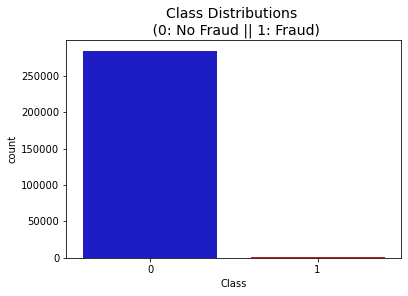

In [6]:
colors = ["#0101DF", "#DF0101"]

sns.countplot('Class', data=df, palette=colors)
pyplot.title('Class Distributions \n (0: No Fraud || 1: Fraud)', fontsize=14)

Observation:
The classes are heavily skewed. Most of the transactions are non-fraud. If we use this dataframe as the base for our predictive models and analysis we might get a lot of errors and our algorithms will probably overfit since it will "assume" that all transactions are not fraud. But we don't want our model to assume this.

In [7]:
df.isnull().sum().max()

0

In [8]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [9]:
# summarizing amount variable
pd.DataFrame(df["Amount"].describe())

,Amount
count,284807.000000
mean,88.349619
std,250.120109
min,0.000000
25%,5.600000
50%,22.000000
75%,77.165000
max,25691.160000


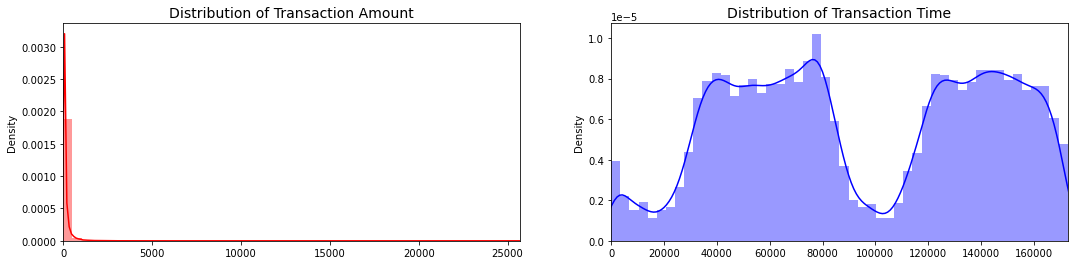

In [10]:
fig, ax = pyplot.subplots(1, 2, figsize=(18,4))

amount_val = df['Amount'].values
time_val = df['Time'].values

sns.distplot(amount_val, ax=ax[0], color='r')
ax[0].set_title('Distribution of Transaction Amount', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])

sns.distplot(time_val, ax=ax[1], color='b')
ax[1].set_title('Distribution of Transaction Time', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])

pyplot.show()

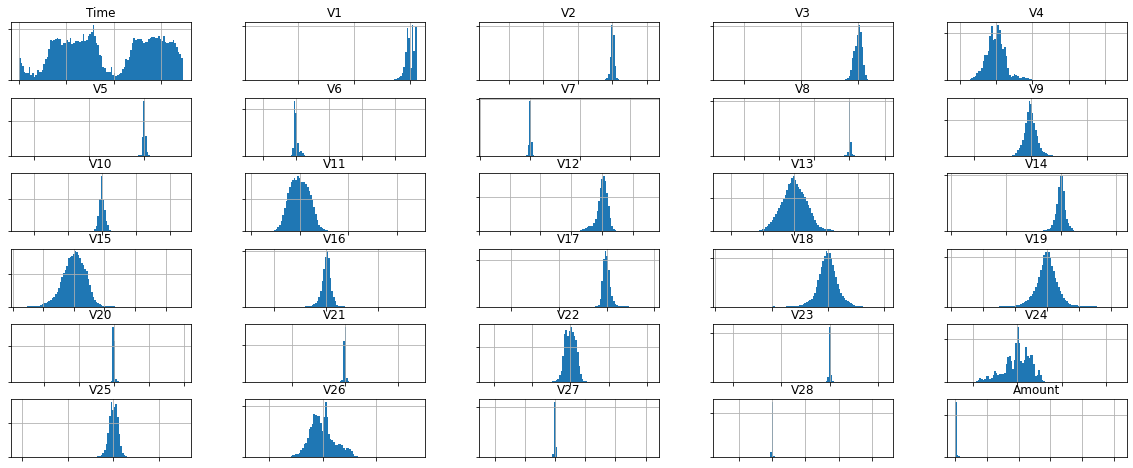

In [11]:
# Ploting histograms of input features
ax = df.iloc[:,:-1].hist(bins=100, figsize=(20,8))
for axis in ax.flatten():
    axis.set_xticklabels([])
    axis.set_yticklabels([])
pyplot.show()

## Data Preprocessing

In [12]:
# Splitting dataset
from sklearn.model_selection import StratifiedShuffleSplit
print('No Frauds', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')
X = df.drop('Class', axis=1)
y = df['Class']

sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in sss.split(X, y):
    print("Train:", train_index, "Test:", test_index)
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset
Train: [ 30473  30496  31002 ... 284804 284805 284806] Test: [    0     1     2 ... 57017 57018 57019]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 30473  30496  31002 ... 113964 113965 113966]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 81609  82400  83053 ... 170946 170947 170948]
Train: [     0      1      2 ... 284804 284805 284806] Test: [150654 150660 150661 ... 227866 227867 227868]
Train: [     0      1      2 ... 227866 227867 227868] Test: [212516 212644 213092 ... 284804 284805 284806]


### 1.Feature Scaling

In [13]:
# RobustScaler aa it is less prone to outliers.
rob_scaler = RobustScaler()

scaled_amount = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
scaled_time = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))

df.insert(0, 'scaled_amount', scaled_amount)
df.insert(1, 'scaled_time', scaled_time)

df.drop(['Time','Amount'], axis=1, inplace=True)
df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.783274,-0.994983,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.269825,-0.994983,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.983721,-0.994972,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.418291,-0.994972,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.670579,-0.994960,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


### 2. Under-Sampling

In [14]:
df = df.sample(frac=1)

# amount of fraud classes 492 rows.
fraud_df = df.loc[df['Class'] == 1]
non_fraud_df = df.loc[df['Class'] == 0][:492]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
216330,-0.209739,0.654871,-0.201124,0.367125,0.024345,-0.665864,1.241630,-1.020070,0.769290,-0.213704,...,-0.040604,0.310592,0.852464,-0.341259,-0.683910,0.283274,-0.093199,0.032763,0.039111,0
42590,-0.233354,-0.511378,-5.932778,4.571743,-9.427247,6.577056,-6.115218,-3.661798,-10.894079,3.709210,...,1.191078,2.014272,-0.167417,0.049968,0.384430,-0.077884,0.565493,1.792012,0.371007,1
15314,0.306574,-0.681305,-0.765070,1.039526,1.179450,-0.085203,0.145014,-0.053280,0.819785,0.016683,...,0.258254,-0.274208,-0.433837,-0.215828,-0.428318,0.161115,0.296739,0.441006,0.220446,0
222419,-0.307413,0.684559,0.457845,1.373769,-0.488926,2.805351,1.777386,0.100492,1.295016,-0.135857,...,-0.264705,0.105593,0.371014,0.051105,0.401524,-0.724766,-0.202881,0.092124,0.094956,1
191359,-0.239363,0.523150,1.177824,2.487103,-5.330608,5.324547,1.150243,-1.281843,-1.171994,0.413778,...,0.156057,0.262325,-0.431790,-0.092088,0.145216,0.457788,0.167739,0.451243,0.268421,1


In [15]:
original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)

print('Class Distributions: \n')
print(train_counts_label/ len(original_ytrain))
print(test_counts_label/ len(original_ytest))

Class Distributions: 

[0.99827076 0.00172924]
[0.99827952 0.00172048]


Distribution of the Classes in the subsample dataset
0    0.5
1    0.5
Name: Class, dtype: float64


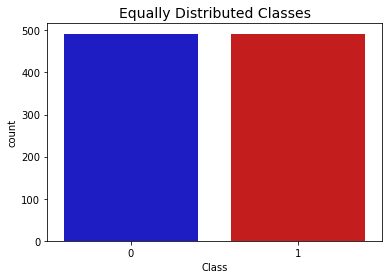

In [16]:
print('Distribution of the Classes in the subsample dataset')
print(new_df['Class'].value_counts()/len(new_df))

sns.countplot('Class', data=new_df, palette=colors)
pyplot.title('Equally Distributed Classes', fontsize=14)
pyplot.show()

Note: The main issue with "Under-Sampling" is that we run the risk that our classification models will not perform as accurate as we would like to since there is a great deal of information loss

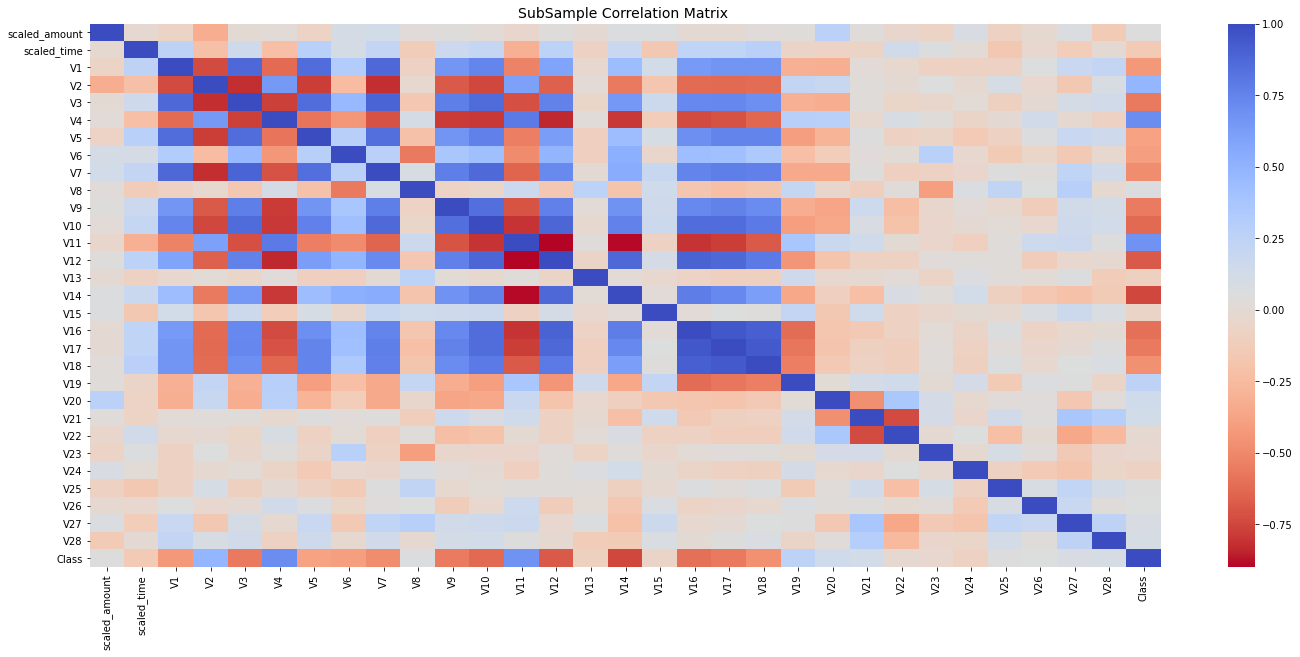

In [17]:
# Correaltion plot data
f, (ax2) = pyplot.subplots(1, 1, figsize=(24,10))
sub_sample_corr = new_df.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax2)
ax2.set_title('SubSample Correlation Matrix ', fontsize=14)
pyplot.show()

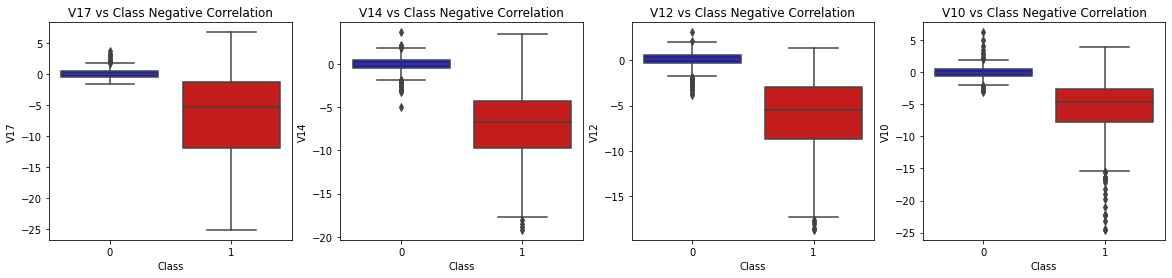

In [18]:
f, axes = pyplot.subplots(ncols=4, figsize=(20,4))

# Negative Correlations with our Class (The lower our feature value the more likely it will be a fraud transaction)
sns.boxplot(x="Class", y="V17", data=new_df, palette=colors, ax=axes[0])
axes[0].set_title('V17 vs Class Negative Correlation')

sns.boxplot(x="Class", y="V14", data=new_df, palette=colors, ax=axes[1])
axes[1].set_title('V14 vs Class Negative Correlation')


sns.boxplot(x="Class", y="V12", data=new_df, palette=colors, ax=axes[2])
axes[2].set_title('V12 vs Class Negative Correlation')


sns.boxplot(x="Class", y="V10", data=new_df, palette=colors, ax=axes[3])
axes[3].set_title('V10 vs Class Negative Correlation')

pyplot.show()

Observations: 
V17, V14, V12 and V10 are negatively correlated. The more likely in the end result will be a fraud transaction for lower values of these variables.

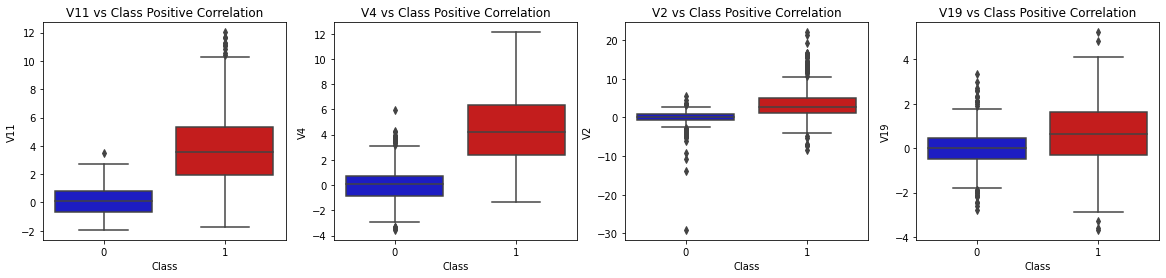

In [19]:
f, axes = pyplot.subplots(ncols=4, figsize=(20,4))

# Positive correlations (The higher the feature the probability increases that it will be a fraud transaction)
sns.boxplot(x="Class", y="V11", data=new_df, palette=colors, ax=axes[0])
axes[0].set_title('V11 vs Class Positive Correlation')

sns.boxplot(x="Class", y="V4", data=new_df, palette=colors, ax=axes[1])
axes[1].set_title('V4 vs Class Positive Correlation')


sns.boxplot(x="Class", y="V2", data=new_df, palette=colors, ax=axes[2])
axes[2].set_title('V2 vs Class Positive Correlation')


sns.boxplot(x="Class", y="V19", data=new_df, palette=colors, ax=axes[3])
axes[3].set_title('V19 vs Class Positive Correlation')

pyplot.show()

Observations:
V2, V4, V11, and V19 are positively correlated. Notice how the higher these values are, the more likely the end result will be a fraud transaction.

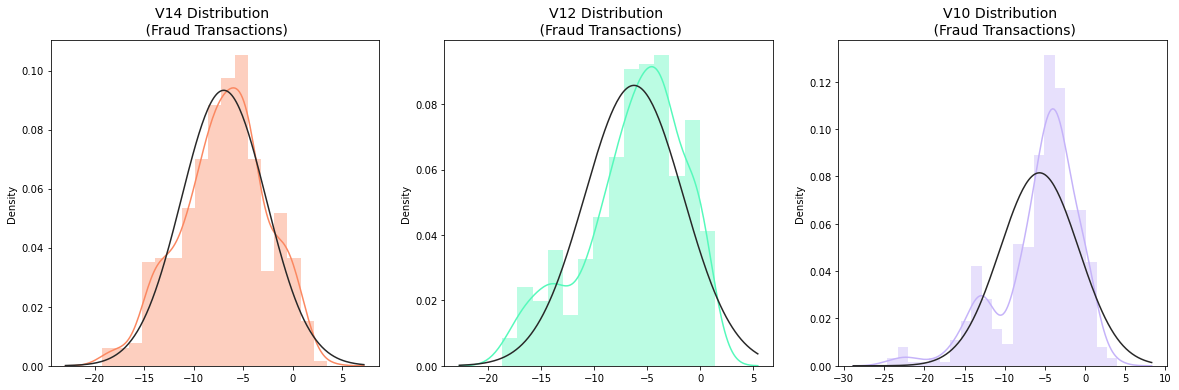

In [20]:
f, (ax1, ax2, ax3) = pyplot.subplots(1,3, figsize=(20, 6))

v14_fraud_dist = new_df['V14'].loc[new_df['Class'] == 1].values
sns.distplot(v14_fraud_dist,ax=ax1, fit=norm, color='#FB8861')
ax1.set_title('V14 Distribution \n (Fraud Transactions)', fontsize=14)

v12_fraud_dist = new_df['V12'].loc[new_df['Class'] == 1].values
sns.distplot(v12_fraud_dist,ax=ax2, fit=norm, color='#56F9BB')
ax2.set_title('V12 Distribution \n (Fraud Transactions)', fontsize=14)


v10_fraud_dist = new_df['V10'].loc[new_df['Class'] == 1].values
sns.distplot(v10_fraud_dist,ax=ax3, fit=norm, color='#C5B3F9')
ax3.set_title('V10 Distribution \n (Fraud Transactions)', fontsize=14)

pyplot.show()

Observatation : 
V14 is the only feature that has a Gaussian distribution compared to features V12 and V10.

### 3. Outliers Treatment

In [21]:
# V14 Removing Outliers (Highest Negative Correlated with Labels)
v14_fraud = new_df['V14'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v14_fraud, 25), np.percentile(v14_fraud, 75)
print('Quartile 25: {} | Quartile 75: {}'.format(q25, q75))
v14_iqr = q75 - q25
print('iqr: {}'.format(v14_iqr))

v14_cut_off = v14_iqr * 1.5
v14_lower, v14_upper = q25 - v14_cut_off, q75 + v14_cut_off
print('Cut Off: {}'.format(v14_cut_off))
print('V14 Lower: {}'.format(v14_lower))
print('V14 Upper: {}'.format(v14_upper))

outliers = [x for x in v14_fraud if x < v14_lower or x > v14_upper]
print('Feature V14 Outliers for Fraud Cases: {}'.format(len(outliers)))
print('V10 outliers:{}'.format(outliers))

new_df = new_df.drop(new_df[(new_df['V14'] > v14_upper) | (new_df['V14'] < v14_lower)].index)
print('----' * 31)

# V12 removing outliers from fraud transactions
v12_fraud = new_df['V12'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v12_fraud, 25), np.percentile(v12_fraud, 75)
v12_iqr = q75 - q25

v12_cut_off = v12_iqr * 1.5
v12_lower, v12_upper = q25 - v12_cut_off, q75 + v12_cut_off
print('V12 Lower: {}'.format(v12_lower))
print('V12 Upper: {}'.format(v12_upper))
outliers = [x for x in v12_fraud if x < v12_lower or x > v12_upper]
print('V12 outliers: {}'.format(outliers))
print('Feature V12 Outliers for Fraud Cases: {}'.format(len(outliers)))
new_df = new_df.drop(new_df[(new_df['V12'] > v12_upper) | (new_df['V12'] < v12_lower)].index)
print('Number of Instances after outliers removal: {}'.format(len(new_df)))
print('----' * 31)


# Removing outliers V10 Feature
v10_fraud = new_df['V10'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v10_fraud, 25), np.percentile(v10_fraud, 75)
v10_iqr = q75 - q25

v10_cut_off = v10_iqr * 1.5
v10_lower, v10_upper = q25 - v10_cut_off, q75 + v10_cut_off
print('V10 Lower: {}'.format(v10_lower))
print('V10 Upper: {}'.format(v10_upper))
outliers = [x for x in v10_fraud if x < v10_lower or x > v10_upper]
print('V10 outliers: {}'.format(outliers))
print('Feature V10 Outliers for Fraud Cases: {}'.format(len(outliers)))
new_df = new_df.drop(new_df[(new_df['V10'] > v10_upper) | (new_df['V10'] < v10_lower)].index)
print('Number of Instances after outliers removal: {}'.format(len(new_df)))

Quartile 25: -9.69272296475 | Quartile 75: -4.2828208495
iqr: 5.40990211525
Cut Off: 8.114853172875002
V14 Lower: -17.807576137625002
V14 Upper: 3.8320323233750013
Feature V14 Outliers for Fraud Cases: 4
V10 outliers:[-19.21432549, -18.49377336, -18.82208674, -18.04999769]
----------------------------------------------------------------------------------------------------------------------------
V12 Lower: -17.343037158875
V12 Upper: 5.776973386125
V12 outliers: [-18.68371463, -18.43113103, -18.04759657, -18.55369701]
Feature V12 Outliers for Fraud Cases: 4
Number of Instances after outliers removal: 976
----------------------------------------------------------------------------------------------------------------------------
V10 Lower: -14.898854632625
V10 Upper: 4.920334958374999
V10 outliers: [-15.56379134, -16.60119697, -15.12416281, -17.14151364, -15.23996196, -15.23183337, -14.92465477, -23.22825484, -22.18708856, -22.18708856, -14.92465477, -15.56379134, -15.23996196, -19.83614

### 4. Splitting the Data 

In [22]:
X = new_df.drop('Class', axis=1)
y = new_df['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [23]:
classifiers = {
    "LogisiticRegression": LogisticRegression(),
    "RandomForestClassifier" : RandomForestClassifier(),
    "XGBClassifier" : XGBClassifier(eval_metric ='error')
}

In [24]:
for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    training_score = cross_val_score(classifier, X_train, y_train, cv=5)
    print("Classifiers: ", classifier.__class__.__name__, "has a training score of", 
          round(training_score.mean(), 2) * 100, "% accuracy score")

Classifiers:  LogisticRegression has a training score of 94.0 % accuracy score
Classifiers:  RandomForestClassifier has a training score of 94.0 % accuracy score
Classifiers:  XGBClassifier has a training score of 94.0 % accuracy score


In [25]:
# Use GridSearchCV to find the best parameters.

# Logistic Regression 
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params)
grid_log_reg.fit(X_train, y_train)
# We automatically get the logistic regression with the best parameters.
log_reg = grid_log_reg.best_estimator_

# Random Forest
rf_params = {"n_estimators" : [50, 100, 200, 300], "max_depth" : [2, 4, 6, 8, 10], "min_samples_leaf" : [1, 5, 10] }
grid_rf = GridSearchCV(RandomForestClassifier(), rf_params)
grid_rf.fit(X_train, y_train)
# Random forest best estimator
rf = grid_rf.best_estimator_

# XGBoost
xgboost_params = {'max_depth': range (2, 10, 1), 'n_estimators': range(60, 220, 40)
                  ,'learning_rate': [0.1, 0.01, 0.05],"eval_metric" :['error']}
grid_xgboost = GridSearchCV(XGBClassifier(objective= 'binary:logistic'), xgboost_params)
grid_xgboost.fit(X_train, y_train)
# XGBoost best estimator
xgboost = grid_xgboost.best_estimator_

best_estimator = {"LogisiticRegression" : log_reg, "RandomForestClassifier" : rf, "XGBClassifier" : xgboost}

In [26]:
for key, classifier in best_estimator.items():
    score = cross_val_score(classifier, X_train, y_train, cv=5)
    print(key +'Cross Validation Score: ', round(score.mean() * 100, 2).astype(str) + '%')

LogisiticRegressionCross Validation Score:  94.05%
RandomForestClassifierCross Validation Score:  94.19%
XGBClassifierCross Validation Score:  95.24%


In [71]:
#undersample during cross validating
undersample_X = df.drop('Class', axis=1)
undersample_y = df['Class']

sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in sss.split(undersample_X, undersample_y):
    print("Train:", train_index, "Test:", test_index)
    undersample_Xtrain, undersample_Xtest = undersample_X.iloc[train_index], undersample_X.iloc[test_index]
    undersample_ytrain, undersample_ytest = undersample_y.iloc[train_index], undersample_y.iloc[test_index]
    
undersample_Xtrain = undersample_Xtrain.values
undersample_Xtest = undersample_Xtest.values
undersample_ytrain = undersample_ytrain.values
undersample_ytest = undersample_ytest.values 

X_nearmiss, y_nearmiss = NearMiss().fit_resample (undersample_X.values, undersample_y.values)
print('NearMiss Label Distribution: {}'.format(Counter(y_nearmiss)))

# Cross Validating the right way
for key, classifier in best_estimator.items():
    undersample_accuracy = []
    undersample_precision = []
    undersample_recall = []
    undersample_f1 = []
    undersample_auc = []

    for train, test in sss.split(undersample_Xtrain, undersample_ytrain):
        
        undersample_pipeline = imbalanced_make_pipeline(NearMiss(sampling_strategy='majority'), classifier)
        undersample_model = undersample_pipeline.fit(undersample_Xtrain[train], undersample_ytrain[train])
        undersample_prediction = undersample_model.predict(undersample_Xtrain[test])

        undersample_accuracy.append(undersample_pipeline.score(original_Xtrain[test], original_ytrain[test]))
        undersample_precision.append(precision_score(original_ytrain[test], undersample_prediction))
        undersample_recall.append(recall_score(original_ytrain[test], undersample_prediction))
        undersample_f1.append(f1_score(original_ytrain[test], undersample_prediction))
        undersample_auc.append(roc_auc_score(original_ytrain[test], undersample_prediction))

Train: [ 56962  56963  56964 ... 284804 284805 284806] Test: [    0     1     2 ... 56959 56960 56961]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 56962  56963  56964 ... 113927 113928 113929]
Train: [     0      1      2 ... 284804 284805 284806] Test: [111813 111989 112029 ... 174320 174870 176099]
Train: [     0      1      2 ... 284804 284805 284806] Test: [170877 170878 170879 ... 227853 227854 227855]
Train: [     0      1      2 ... 227853 227854 227855] Test: [222268 222306 222434 ... 284804 284805 284806]
NearMiss Label Distribution: Counter({0: 492, 1: 492})


LogisticRegression has a roc score of 0.938531480288044
RandomForestClassifier has a roc score of 0.9311937851999215
XGBClassifier has a roc score of 0.950856706548236


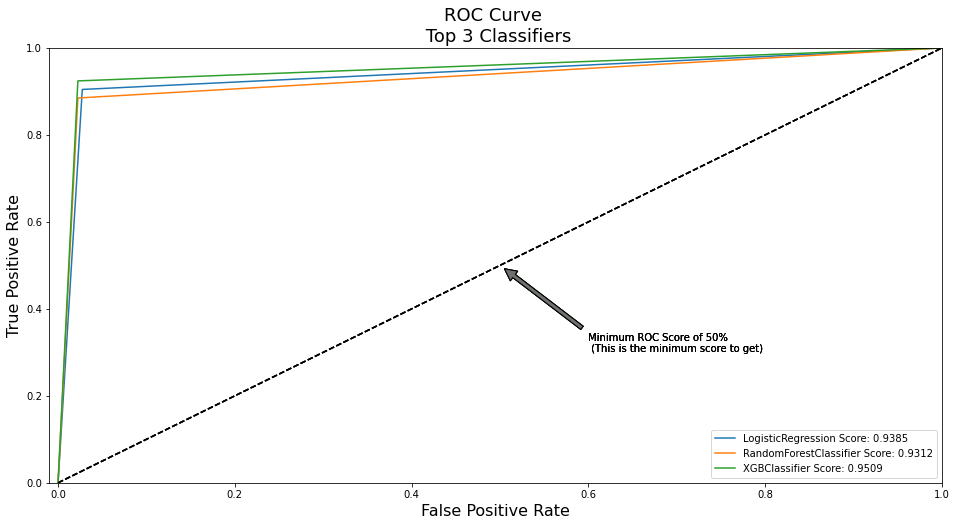

In [28]:
best_estimator = {"LogisiticRegression" : log_reg, "RandomForestClassifier" : rf, "XGBClassifier" : xgboost}
# Create a DataFrame with all the scores and the classifiers names.
pyplot.figure(figsize=(16,8))
pyplot.title('ROC Curve \n Top 3 Classifiers', fontsize=18)

for key, classifier in best_estimator.items():
    pred = cross_val_predict(classifier, X_train, y_train, cv=5)
    fpr, tpr, thresold = roc_curve(y_train, pred)
    pyplot.plot(fpr, tpr, label=(classifier.__class__.__name__)+' Score: {:.4f}'.format(roc_auc_score(y_train, pred)))
    pyplot.plot([0, 1], [0, 1], 'k--')
    pyplot.axis([-0.01, 1, 0, 1])
    pyplot.xlabel('False Positive Rate', fontsize=16)
    pyplot.ylabel('True Positive Rate', fontsize=16)
    pyplot.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', xy=(0.5, 0.5), xytext=(0.6, 0.3),
                arrowprops=dict(facecolor='#6E726D', shrink=0.05),
                )
    pyplot.legend()
    print(classifier.__class__.__name__, "has a roc score of",roc_auc_score(y_train, pred))


In [86]:
undersample_average_precision = average_precision_score(original_ytest, undersample_probabilities[:, 1])

print('Average precision-recall score: {0:0.4f}'.format(
      undersample_average_precision))

Average precision-recall score: 0.0014


Text(0.5, 1.0, 'UnderSampling Precision-Recall curve: \n Average Precision-Recall Score =0.0014')

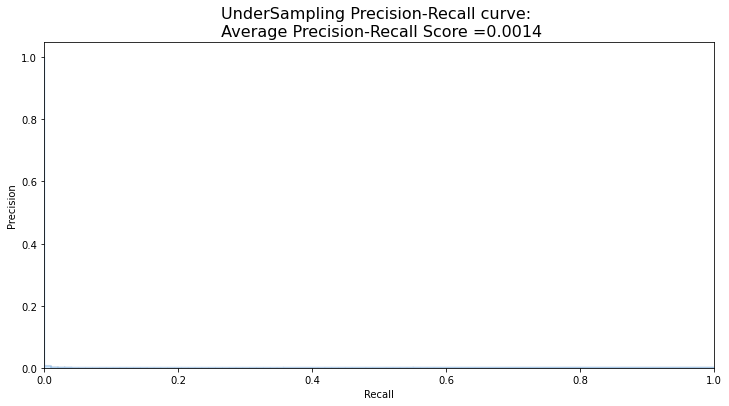

In [88]:
fig = pyplot.figure(figsize=(12,6))

precision, recall, _ = precision_recall_curve(original_ytest, undersample_probabilities[:, 1])

pyplot.step(recall, precision, color='#004a93', alpha=0.2,
         where='post')
pyplot.fill_between(recall, precision, step='post', alpha=0.2,
                 color='#48a6ff')

pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.ylim([0.0, 1.05])
pyplot.xlim([0.0, 1.0])
pyplot.title('UnderSampling Precision-Recall curve: \n Average Precision-Recall Score ={0:0.4f}'.format(
          undersample_average_precision), fontsize=16)

## SMOTE Technique

In [116]:
print('Length of X (train): {} | Length of y (train): {}'.format(len(original_Xtrain), len(original_ytrain)))
print('Length of X (test): {} | Length of y (test): {}'.format(len(original_Xtest), len(original_ytest)))

# XGBoost Parameters
xgboost_params = {'max_depth': range (2, 10, 1), 'n_estimators': range(60, 220, 40)
                  ,'learning_rate': [0.1, 0.01, 0.05],"eval_metric" :["auc","map","aucpr"]}

rs_xgboost = RandomizedSearchCV(XGBClassifier(objective= 'binary:logistic'), xgboost_params, n_iter=4)
    
# List to append the scores and then find the average
accuracy_lst = []
precision_lst = []
recall_lst = []
f1_lst = []
auc_lst = []

# Implementing SMOTE Technique 
# Cross Validating the right way
for train, test in sss.split(original_Xtrain, original_ytrain):
    pipeline = imbalanced_make_pipeline(SMOTE(sampling_strategy='minority'), rs_xgboost) # SMOTE happens during Cross Validation not before..
    model = pipeline.fit(original_Xtrain[train], original_ytrain[train])
    best_est = rs_xgboost.best_estimator_
    prediction = best_est.predict(original_Xtrain[test])

    accuracy_lst.append(accuracy_score(original_ytrain[test], prediction))
    precision_lst.append(precision_score(original_ytrain[test], prediction))
    recall_lst.append(recall_score(original_ytrain[test], prediction))
    f1_lst.append(f1_score(original_ytrain[test], prediction))
    auc_lst.append(roc_auc_score(original_ytrain[test], prediction))

print('---' * 42)
print('')
print("accuracy: {}".format(np.mean(accuracy_lst)))
print("precision: {}".format(np.mean(precision_lst)))
print("recall: {}".format(np.mean(recall_lst)))
print("f1: {}".format(np.mean(f1_lst)))

Length of X (train): 227846 | Length of y (train): 227846
Length of X (test): 56961 | Length of y (test): 56961
------------------------------------------------------------------------------------------------------------------------------

accuracy: 0.9836294243572192
precision: 0.2793997463957034
recall: 0.8073677377474846
f1: 0.27399987854503555


In [117]:
labels = ['No Fraud', 'Fraud']
smote_prediction = best_est.predict(original_Xtest)
print(classification_report(original_ytest, smote_prediction, target_names=labels))

              precision    recall  f1-score   support

    No Fraud       1.00      1.00      1.00     56863
       Fraud       1.00      0.46      0.63        98

    accuracy                           1.00     56961
   macro avg       1.00      0.73      0.81     56961
weighted avg       1.00      1.00      1.00     56961



In [118]:
probabilities = best_est.predict_proba(original_Xtest)
average_precision = average_precision_score(original_ytest, probabilities[:, 1])

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Average precision-recall score: 0.80


In [119]:
average_precision = average_precision_score(original_ytest, probabilities[:, 1])

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Average precision-recall score: 0.80


Text(0.5, 1.0, 'OverSampling Precision-Recall curve: \n Average Precision-Recall Score =0.80')

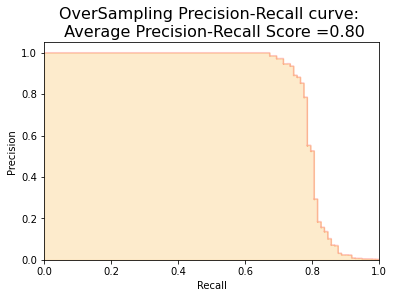

In [120]:
precision, recall, _ = precision_recall_curve(original_ytest, probabilities[:, 1])

pyplot.step(recall, precision, color='r', alpha=0.2,
         where='post')
pyplot.fill_between(recall, precision, step='post', alpha=0.2,
                 color='#F59B00')

pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.ylim([0.0, 1.05])
pyplot.xlim([0.0, 1.0])
pyplot.title('OverSampling Precision-Recall curve: \n Average Precision-Recall Score ={0:0.2f}'.format(
          average_precision), fontsize=16)

In [121]:
# SMOTE Technique (OverSampling) After splitting and Cross Validating
sm = SMOTE(sampling_strategy ='minority', random_state=42)
val_sm  = sm.fit_resample(original_Xtrain, original_ytrain)
Xsm_train, ysm_train = val_sm[0],val_sm[1]

t0 = time.time()
xgboost_sm = rs_xgboost.best_estimator_
xgboost_sm.fit(Xsm_train, ysm_train)
t1 = time.time()
print("Fitting oversample data took :{} sec".format(t1 - t0))

Fitting oversample data took :9935.911217212677 sec


In [128]:
# XGBoost fitted using SMOTE technique
y_pred = xgboost_sm.predict(X_test)
cf = confusion_matrix(y_test, y_pred)

<AxesSubplot:>

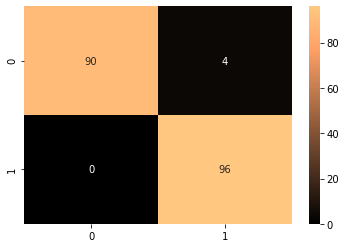

In [130]:
sns.heatmap(cf, annot=True, cmap=pyplot.cm.copper)

A high area under the curve represents both high recall and high precision, where high precision relates to a low false positive rate, and high recall relates to a low false negative rate. High scores for both show that the classifier is returning accurate results (high precision), as well as returning a majority of all positive results (high recall).